In [95]:
import numpy as np
import pandas as pd
from numpy import pi, exp, log
from numpy import dot, multiply, diag, power
from numpy.linalg import inv, eig, pinv
import matplotlib.pyplot as plt

In [96]:
# 実際のデータを用いてやってみる
df = pd.read_csv("data/dynamics/p.csv")
# 最初のデータ10個は死んでる
df = df[10:]

F = df["point1"].values

def normalize(x):
	"""1次元"""
	mu = np.mean(x)
	s = np.std(x)
	return (x - mu) / s

# 真の値
# 正規化
F = normalize(F)
N = len(F)
print("N:", N)
t_raw = np.linspace(0, 1, N)
dt = t_raw[2] - t_raw[1]

N: 67


In [97]:
# 前処理(Hanakel行列化)
# N: 時系列の長さ, L: 任意のwinidowの大きさ, Nの半分以下にしないといけない
L = 30
K = N - L + 1
D = np.column_stack([F[i : i + L] for i in range(0, K)])
D.shape # (1windowに格納されている状態ベクトルの数, スナップショットの数)

X = D[:, :-1]  # スナップショット群1
Y = D[:, 1:]  # スナップショット群2
t = np.arange(0, K - 1)  # スナップショット群に対するtime

In [98]:
def dmd(X, Y, r):
	U2, Sig2, Vh2 = np.linalg.svd(X)
	# 寄与率
	sigma_sumsq = (Sig2 ** 2).sum()
	cumlative_contrib = (Sig2[:r] ** 2).cumsum() / sigma_sumsq * 100
	contrib = (Sig2[:r] ** 2) / sigma_sumsq * 100

	U = U2[:,:r]
	Sig = diag(Sig2)[:r,:r]  # 対角行列を作って、それのrランク
	V = Vh2.conj().T[:,:r]  # conjは共役複素数

	Atil = dot(dot(dot(U.conj().T, Y), V), inv(Sig))
	mu, W = eig(Atil)  # 固有値と固有ベクトルを作成

	# 時間発展
	Phi = dot(dot(dot(Y, V), inv(Sig)), W)
	b = dot(pinv(Phi), X[:, 0])
	Psi = np.zeros([r, len(t)], dtype="complex")
	for idx, mu_elem in enumerate(mu):
		for _k in t:
			Psi[idx, _k] = exp(log(mu_elem) / dt * _k * dt) * b[idx]

	# 評価関数
	Db = diag(b)
	Vand = np.array([mu**i for i in range(0, K-1)]).T
	J = np.linalg.norm(X - np.dot(Phi, np.dot(Db, Vand)), "fro")


	# Compute DMD reconstruction for each mode
	x_t_list = []
	for idx, mu_elem in enumerate(mu):
		x_t = []
		for t_ in t:
			x_t.append(Phi[:, idx] * exp(log(mu_elem) / dt * t_ * dt) * b[idx])
		x_t = np.array(x_t).T
		x_t_list.append(x_t)
		# x_t_listには各モードの時間発展がかくのうされている

	def X_to_TS(x_t):
		x0 = x_t[:, 0]
		x1 = x_t[-1, 1:]
		ts = np.concatenate([x0, x1], 0)
		return ts



	# Convert Hankel matrix to time-series
	x_t_recon = []
	for x_t in x_t_list:
		x_t_recon.append(X_to_TS(x_t))
	x_t_recon = np.array(x_t_recon)
	F_recon = x_t_recon.sum(axis=0)

	return F_recon, b, J, contrib

In [110]:
ranks = np.arange(1, 30, 1, dtype=np.int16)
results = [dmd(X=X, Y=Y, r=r) for r in ranks]

Fs = np.array([result[0] for result in results])  # (rank, time)
bs = [result[1] for result in results]  # (rank, mode) 
Js = [result[2] for result in results]  # (rank)
sum_contribs = [np.sum(result[3]) for result in results]  # (rank, mode)

g1s = [np.sum(np.abs(b)) for b in bs]  # (rank)
g2s = [np.sum(np.abs(b)**2) for b in bs]  # (rank)

# hyper-parameter
gamma1 = 0.2
gamma2 = 0.3
eta = 1

i_ranks = range(len(ranks))
evals = [Js[i] + gamma1 * g1s[i] + gamma2 * g2s[i] for i in i_ranks]
evals = np.array(evals)
i_min_eval = np.argmin(evals)
evals

array([48.33810605, 18.04296584, 24.99554032, 21.84624716, 22.04681608,
       18.15165484, 22.17459886, 22.49725144, 26.07348492, 17.27260205,
       22.25329862, 20.23820753, 22.61736084, 23.89156357, 18.43215078,
       18.3249802 , 17.44939424, 20.48876634, 31.44230725, 22.34520315,
       26.66849724, 26.44546106, 28.37614539, 27.22070092, 27.91860195,
       25.2540704 , 25.68933291, 23.13275802, 25.91232192])

/home/ayumu/Documents/MAZIN/DynamicModeDecomposition/myvenv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


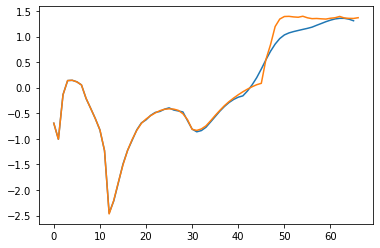

In [100]:
plt.plot(range(len(F_recon)), F_recon)
plt.plot(range(len(F)), F)